# HybridNetv7HE Report

Jakob Balkovec<br>
Sat Sep 13th 2025<br>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
from matplotlib.patches import Patch
import matplotlib.image as mpimg

ROOT_DIR = r'/Users/jbalkovec/Desktop/DR/experiments/model_logs/v7HE/output'
PATHS = {
  'per_image_test': os.path.join(ROOT_DIR, 'test_per_image_metrics.csv'),
  'metrics': os.path.join(ROOT_DIR, 'metrics_expanded.csv'),
  'split': os.path.join(ROOT_DIR, 'metrics_logs/split_summary.csv'),
}

## Utility Functions

In [2]:
def get_color(d):
    if d < 0.4:
        return "red"
    elif d < 0.5:
        return "yellow"
    else:
        return "green"

def plot_scatter_per_img_dice(df):
    plt.figure(figsize=(10, 8))
    plt.scatter(
        df["dice"],
        df["idx"],
        c=df["color"],
        s=80,
        marker="o",
        edgecolor="k",
        alpha=0.9
    )

    plt.axvline(0.4, color="red", linestyle="--", alpha=0.7, linewidth=1.2)
    plt.axvline(0.5, color="green", linestyle="--", alpha=0.7, linewidth=1.2)

    plt.xlabel("Dice Score", fontsize=13)
    plt.ylabel("Image Index", fontsize=13)
    plt.title("Per-Image Dice Scores", fontsize=15, fontweight="bold")

    legend_elements = [
        Patch(facecolor="red", edgecolor="k", label="Dice < 0.4"),
        Patch(facecolor="yellow", edgecolor="k", label="0.4 ≤ Dice < 0.5"),
        Patch(facecolor="green", edgecolor="k", label="Dice ≥ 0.5"),
    ]
    plt.legend(handles=legend_elements, title="Score Ranges", loc="lower right", frameon=True)

    plt.grid(axis="x", linestyle="--", alpha=0.6)
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()

BANDS = {
    "loss": {
        "good": (0.0, 0.25),
        "mid":  (0.25, 0.45),
        "bad":  (0.45, float("inf")),
    },
    "dice": {
        "bad":  (0.0, 0.40),
        "mid":  (0.40, 0.60),
        "good": (0.60, 1.0),
    },
    "iou": {
        "bad":  (0.0, 0.30),
        "mid":  (0.30, 0.45),
        "good": (0.45, 1.0),
    },
    "pearson": {
        "bad":  (0.0, 0.30),
        "mid":  (0.30, 0.50),
        "good": (0.50, 1.0),
    },
}

BAND_COLORS = {"bad": "#F44336", "mid": "#FFC107", "good": "#4CAF50"}

def _get_epoch_x(df):
    if "epoch" in df.columns:
        return df["epoch"].values
    return (df.index.values + 1)

def _shade_bands(ax, metric, x_min, x_max, alpha=0.15):
    if metric not in BANDS:
        return

    for band in ("bad", "mid", "good"):
        lo, hi = BANDS[metric][band]
        ax.axhspan(lo, hi if hi != float("inf") else ax.get_ylim()[1],
                   color=BAND_COLORS[band], alpha=alpha, zorder=0, linewidth=0)

def plot_metric(df, metric, title=None, ylim=None):
    tr_col = f"train_{metric}"
    va_col = f"val_{metric}"
    if tr_col not in df.columns or va_col not in df.columns:
        raise ValueError(f"Expected columns '{tr_col}' and '{va_col}' in df")

    x = _get_epoch_x(df)
    y_tr = df[tr_col].values
    y_va = df[va_col].values

    fig, ax = plt.subplots(figsize=(8, 5))

    y_min = min(y_tr.min(), y_va.min())
    y_max = max(y_tr.max(), y_va.max())
    if ylim is None:
        if metric in ("dice", "iou", "pearson"):
            ylim = (0.0, 1.0)
        else:
            ylim = (max(0.0, y_min * 0.9), y_max * 1.1)

    ax.set_ylim(*ylim)
    _shade_bands(ax, metric, x_min=x.min(), x_max=x.max(), alpha=0.18)

    ax.plot(x, y_tr, marker="o", linewidth=1.8, markersize=5, label=f"train_{metric}")
    ax.plot(x, y_va, marker="s", linewidth=1.8, markersize=5, label=f"val_{metric}")

    ax.set_xlabel("Epoch")
    ax.set_ylabel(metric.capitalize())
    ax.set_title(title or f"{metric.capitalize()} (train vs val)")
    ax.grid(True, axis="both", linestyle="--", alpha=0.4)
    ax.legend(loc="best", frameon=True)

    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)

    plt.tight_layout()
    return fig, ax

def plot_panel(img):
    plt.figure(figsize=(10, 16))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Best Panel")
    plt.show()

In [3]:
per_image_test_df = pd.read_csv(PATHS['per_image_test'])
metrics_df = pd.read_csv(PATHS['metrics'])

## Per-Image Test Results

This is here to analyze per-image dice scores, and rule out the outliers.

#### Tail

In [4]:
sorted_per_img = per_image_test_df.sort_values('dice')
sorted_per_img.head(n=10)

,image_id,dice,iou,precision,recall,pearson
66,0335_1,2.216312e-10,2.216312e-10,0.0,0.0,0.120128
268,1647_3,2.579314e-10,2.579314e-10,0.0,0.0,0.000000
207,0970_1,8.130081e-10,8.130081e-10,0.0,0.0,0.000000
213,0991_1,1.019368e-09,1.019368e-09,0.0,0.0,0.023657
199,0945_1,1.123596e-09,1.123596e-09,0.0,0.0,0.198526
210,0983_1,1.156069e-09,1.156069e-09,0.0,0.0,0.000000
254,1410_1,1.223990e-09,1.223990e-09,0.0,0.0,0.000000
189,0902_1,1.234568e-09,1.234568e-09,0.0,0.0,0.002447
227,1055_1,1.278772e-09,1.278772e-09,0.0,0.0,0.374827
1,0004_1,1.321004e-09,1.321004e-09,0.0,0.0,0.220237


#### Head

In [5]:
sorted_per_img.tail(n=10)

,image_id,dice,iou,precision,recall,pearson
252,1283_1,1.0,1.0,0.0,0.0,0.0
231,1070_1,1.0,1.0,0.0,0.0,0.0
250,1191_1,1.0,1.0,0.0,0.0,0.0
249,1187_1,1.0,1.0,0.0,0.0,0.0
234,1081_1,1.0,1.0,0.0,0.0,0.0
247,1165_1,1.0,1.0,0.0,0.0,0.0
236,1087_1,1.0,1.0,0.0,0.0,0.0
237,1090_1,1.0,1.0,0.0,0.0,0.0
239,1094_1,1.0,1.0,0.0,0.0,0.0
275,1826_1,1.0,1.0,0.0,0.0,0.0


This doesn't really mean anything, since the tail is just images with no masks, and head is the images with the largest masks. Setting a threshold for dice scores to be above 0.5 seems reasonable. Anything above that is good, anything below that is considered a failure.

In [18]:
print("MEAN: ", per_image_test_df["dice"].mean().round(3))

MEAN:  0.446


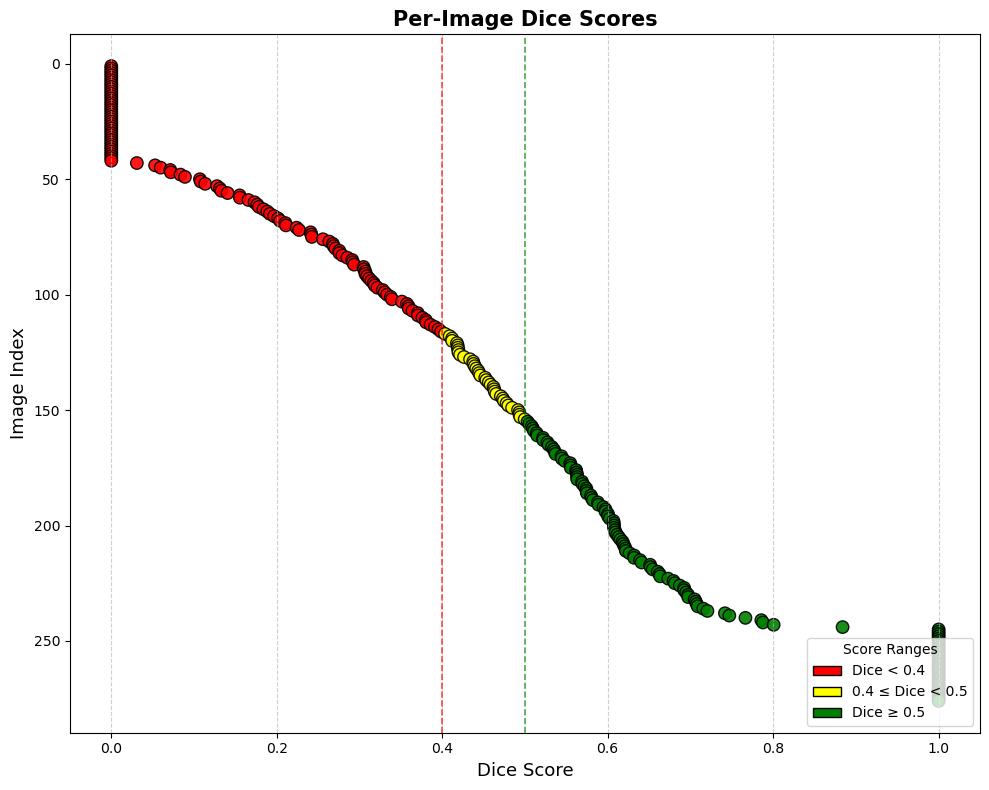

In [6]:
per_image_test_df["color"] = per_image_test_df["dice"].apply(get_color)
per_image_test_df = per_image_test_df.sort_values("dice").reset_index(drop=True)
per_image_test_df["idx"] = per_image_test_df.index + 1  # 1-based

plot_scatter_per_img_dice(per_image_test_df)

As I mentioned above, a dice score of 1 means that the predicted mask matches the ground truth perfectly. From my brief analysis, the images with a dice score of 1 have no masks/blank masks. A dice score of 0 means that there is no overlap at all:

- The model completely failed to detect the annotated lesions (missed all true lesions), 
- The model predicted lesions in entirely different regions of the fundus where none exist in the ground truth.

#### Removing Outliers

In [7]:
filtered_df = per_image_test_df[(per_image_test_df["dice"] > 0.05) & (per_image_test_df["dice"] < 0.99)]
print("New length: ", len(filtered_df), " vs. Old length: ", len(per_image_test_df))

New length:  201  vs. Old length:  276


`USING LOWER_BOUND == 0.05 && UPPER_BOUND == 0.99`

- I set the lower bound to be 0.05 to exclude the images where the model completely failed to detect any lesions. 
- I set the upper bound to be 0.99 to exclude the images where there are no lesions in the ground truth, which results in a dice score of 1. These outliers can skew the mean dice score and give a false impression of the model's performance.

`75 OUTLIERS`

**Note:** Compared to 130 with EX

Now that the `75` outliers have been identified and removed, we can calculate a more accurate mean dice score. Note that these are not the dice scores obtained during training, but the dice scores calculated on the test set after training.

`SCALED UP`

If 276 images have 75 outliers, that means that 27.2% of the images are outliers. Scaling this up to the full dataset of 1820 images, we can expect around 495 images to be outliers. This is a significant portion of the dataset, and it highlights the importance of addressing these outliers in order to improve the overall performance of the model...

In [17]:
print("True MEAN: ", filtered_df["dice"].mean().round(3))
print("True MEDIAN: ", round(filtered_df["dice"].median(), ndigits=3))

True MEAN:  0.453
True MEDIAN:  0.471


Now this is the actual mean dice score after removing the outliers. it indicates poor performance, but this is expected given the difficulty of the task and the presence of many challenging images in the dataset...It's not too far off from the mean dice score over all images, which was 0.446. This suggests that the outliers were not drastically skewing the overall performance metrics, but their removal does provide a clearer picture of the model's capabilities on more typical cases.

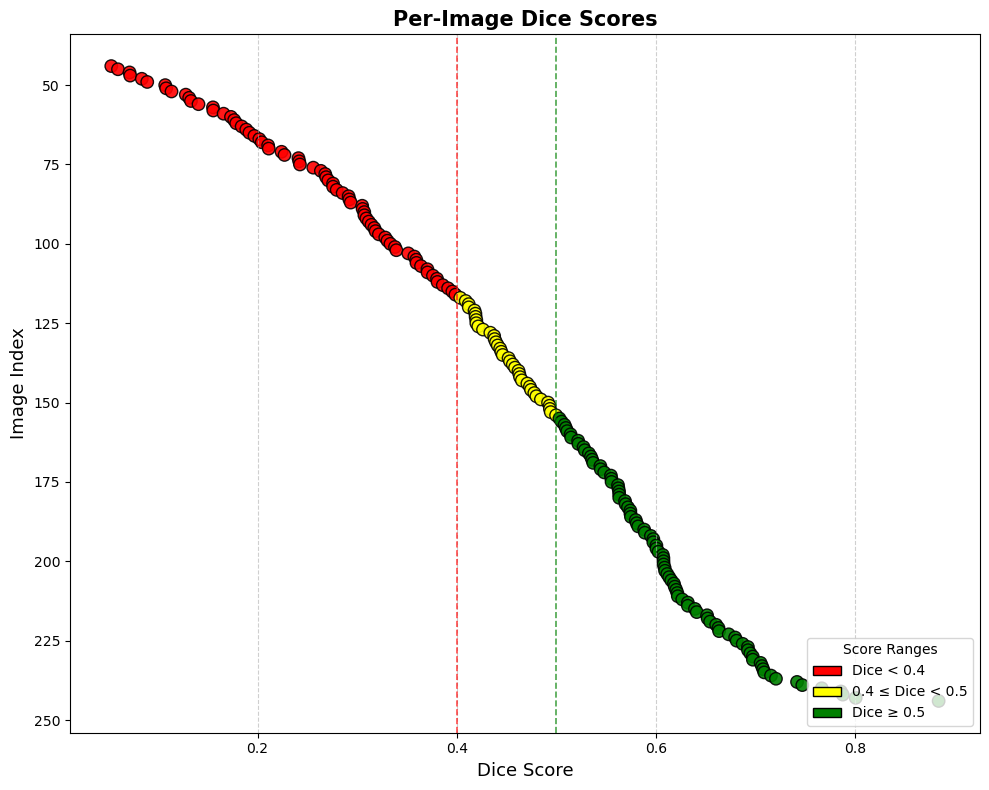

In [19]:
plot_scatter_per_img_dice(filtered_df)

## Standard Metrics

In [21]:
metrics_df.head(n=19)

,epoch,train_loss,val_loss,train_dice,val_dice,train_iou,val_iou,train_pearson,val_pearson
0,1,0.968411,0.677540,0.483806,0.284297,0.323804,0.195584,0.547002,0.322891
1,2,0.776872,0.732543,0.316514,0.154941,0.189057,0.091572,0.455076,0.237831
2,3,0.728324,0.682906,0.390110,0.359248,0.247681,0.257740,0.537096,0.366225
3,4,0.574535,0.670175,0.510248,0.360157,0.350687,0.255101,0.523154,0.381091
4,5,0.534667,0.656287,0.355545,0.463113,0.235461,0.362486,0.454345,0.410690
5,6,0.523379,0.696245,0.429894,0.387024,0.274029,0.286943,0.484529,0.370492
6,7,0.471458,0.647355,0.377479,0.496776,0.274741,0.399952,0.437302,0.415289
7,8,0.435209,0.652717,0.204396,0.453777,0.128453,0.363283,0.287356,0.380780
8,9,0.411727,0.614998,0.163955,0.481233,0.089773,0.398314,0.341196,0.434366
9,10,0.404841,0.618536,0.485291,0.468434,0.356631,0.369202,0.582660,0.421008


#### Dice

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Training and Validation Dice Over Epochs'}, xlabel='Epoch', ylabel='Dice'>)

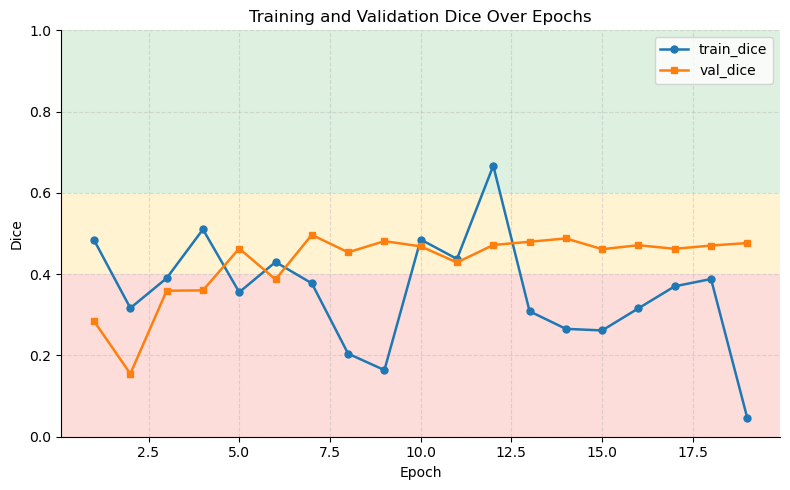

In [22]:
plot_metric(metrics_df, "dice", title="Training and Validation Dice Over Epochs")

#### IoU

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Training and Validation IoU Over Epochs'}, xlabel='Epoch', ylabel='Iou'>)

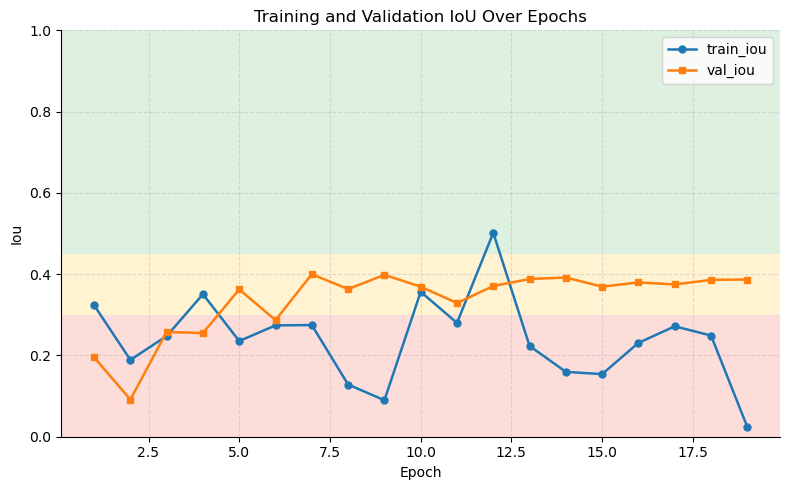

In [23]:
plot_metric(metrics_df, "iou", title="Training and Validation IoU Over Epochs")

#### Pearson's R

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': "Training and Validation Pearson's R Over Epochs"}, xlabel='Epoch', ylabel='Pearson'>)

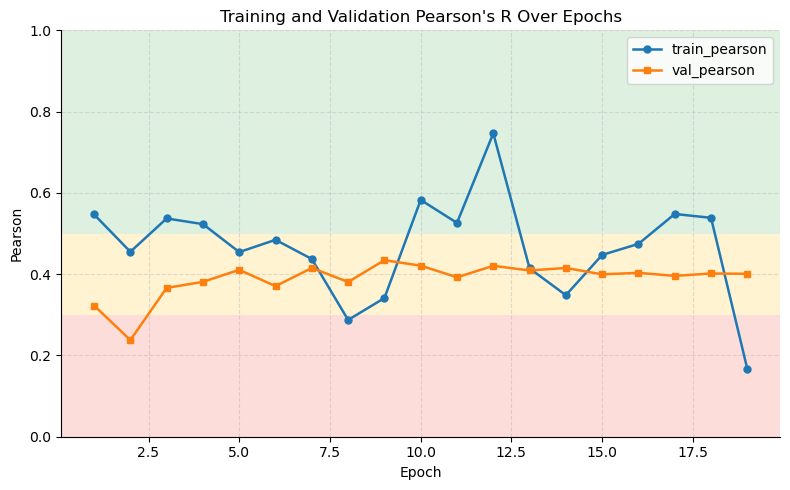

In [24]:
plot_metric(metrics_df, "pearson", title="Training and Validation Pearson's R Over Epochs")

The metrics don't look horrible, but they're not great either. This could be a mild case of overfitting I guess, but I think a bigger problem is that the model is just not powerful enough to capture the complexity of the data. The training and validation metrics are pretty close, which suggests that the model is learning something useful, but it's not learning it well enough to generalize to new data...

## Low-Dice Panels

#### Best

The panels with high dice (< 0.95) are not worth plotting since they're just images with no lesions. The model predicts no lesions, which is correct, but the dice score is 1 because there are no true positives. I plotted 1 just an example.

Note that the grid pattern is as follows:

| IMG + M1 | PRED M1   | PRED  M2  |
|------|------|------|
| IMG + M2 | IMG + M3 | PRED M3 |


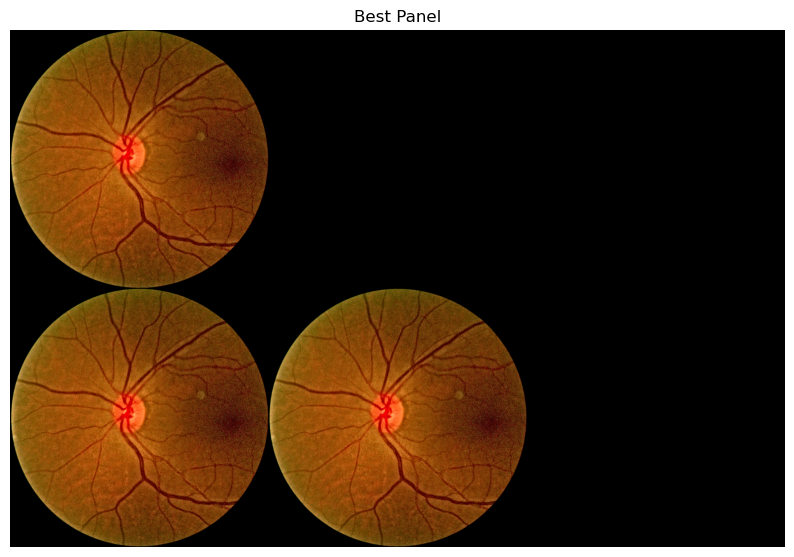

In [28]:
path = r'/Users/jbalkovec/Desktop/DR/experiments/model_logs/v7HE/output/error_analysis_HE/best/00_1818_1_dice1.000.png'
img = mpimg.imread(path)

plot_panel(img)

#### Worst

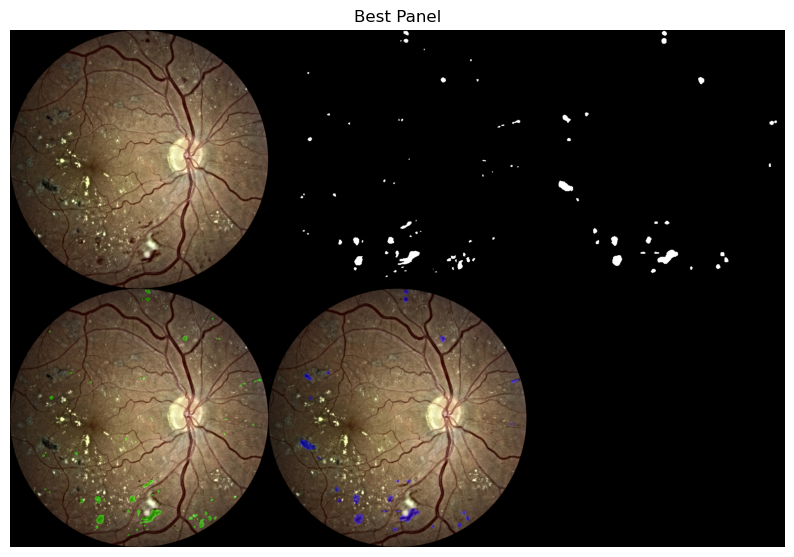

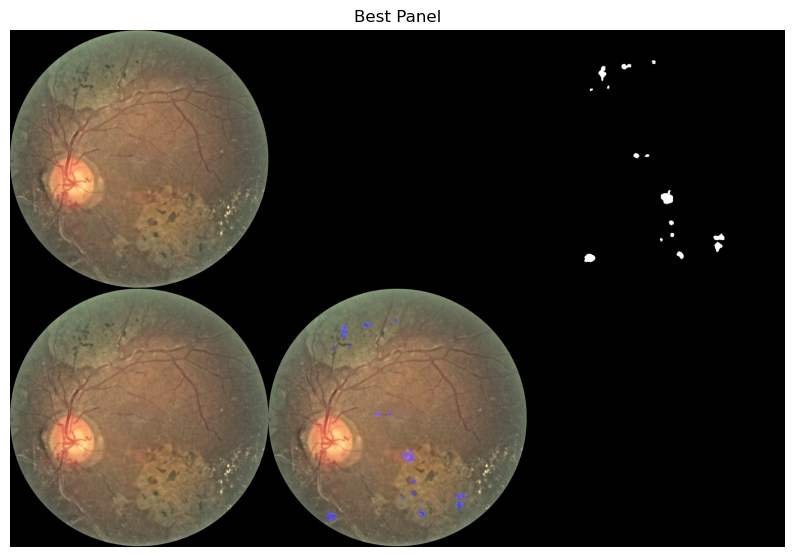

In [29]:
PANEL1 = r'/Users/jbalkovec/Desktop/DR/experiments/model_logs/v7HE/output/error_analysis_HE/0098_3_panel.png'
PANEL2 = r'/Users/jbalkovec/Desktop/DR/experiments/model_logs/v7HE/output/error_analysis_HE/1801_3_panel.png'

plot_panel(mpimg.imread(PANEL1))
plot_panel(mpimg.imread(PANEL2))

So the goal of this was to identify pattern(s) that hurt the dice score. I don't really see a definitive pattern, but I do see a common theme, that is if the lesion is relatively small, e.g. meaning a lot of background, the model tends to miss it/struggle. This is especially true if the lesion is in a tricky spot, like near the optic disc or fovea. The model seems to have a hard time distinguishing between actual lesions and other features of the retina, like blood vessels or reflections.

I'm curious to see if Daniel and Alyssa notice the same patterns when they do their analysis. It would be interesting to see if they come to the same conclusions, or if they notice different things that I missed...

## Further Investigation

Since I felt like this wasn't enough, I decided to compile a list of images with low (close to 0) dice score and investigate them further. I was mostly focused on predicted masks vs ground truth masks. 

```
image_ids_zero = [0004_1, 0119_1, 0335_1, 0465_1, 0559_1, 0644_1, 0672_1, 0745_1, 0762_1, 0805_1, ...]
imgaes_ids_low = image_ids = [0004_1, 0029_1, 0072_2, 0104_1, 0108_1, 0119_1, 0162_1, 0179_1, 0212_1, 0271_1, ...]
```



#### Zero Dice Breakdown

In [30]:
zero_dice_df = pd.read_csv(r'/Users/jbalkovec/Desktop/DR/experiments/model_logs/v7HE/output/per_image_analysis/zero_dice_breakdown.csv')

In [31]:
case_counts = zero_dice_df["case"].value_counts()
print("\nCounts per failure type:\n", case_counts)


Counts per failure type:
 case
A_GT_empty_PRED_nonempty    13
B_GT_nonempty_PRED_empty    10
C_disjoint                   5
Name: count, dtype: int64


Each "case" describes why the Dice score is 0:
- `A_GT_empty_PRED_nonempty` means Ground truth mask is empty (no lesions),
  but the model predicted lesions anyway  = false positives.

- `B_GT_nonempty_PRED_empty` means Ground truth mask has lesions,
  but the model predicted nothing = false negatives.

- `C_disjoint` means Both GT and prediction are non-empty,
  but they do not overlap at all = mislocalization (wrong region).

In [32]:
case_percent = zero_dice_df["case"].value_counts(normalize=True) * 100
print("\nPercentages per failure type:\n", case_percent)


Percentages per failure type:
 case
A_GT_empty_PRED_nonempty    46.428571
B_GT_nonempty_PRED_empty    35.714286
C_disjoint                  17.857143
Name: proportion, dtype: float64


Most of the problems came from two main failure types. About 46% of the time the ground truth had no lesion but the model still predicted one, meaning it’s often seeing things that aren’t really there. 

On the other hand, around 36% of cases were the opposite...the ground truth had a lesion but the model completely missed it. 

The remaining 18% were situations where both sides had something, but they didn’t overlap, so the model was marking the wrong spot. 

Overall, the model tends to swing between overcalling and undercalling, with a smaller chunk of pure mislocalization.

In [33]:
print("\nGround truth pixel stats:")
print(zero_dice_df["gt_pixels"].describe())


Ground truth pixel stats:
count       28.000000
mean      2276.214286
std       4151.903520
min          0.000000
25%          0.000000
50%        890.500000
75%       3633.500000
max      21184.000000
Name: gt_pixels, dtype: float64


In [34]:
print("\nPrediction pixel stats:")
zero_dice_df["pred_pixels"].describe()


Prediction pixel stats:


count       28.000000
mean      2311.357143
std       4825.119068
min          0.000000
25%          0.000000
50%        761.500000
75%       1673.250000
max      24239.000000
Name: pred_pixels, dtype: float64

`[OUTPUT 1 — Ground Truth]`
Looking at the ground truth masks for these failed cases, lesion sizes are all over the place. The average is ~2,300 pixels, but the spread is massive (std >4,000). Half the images have fewer than ~900 pixels labeled, and a quarter of them are completely empty. At the other end, a few go up past 20,000 pixels. So failures aren’t just about missing tiny lesions — they’re also happening when lesions are large, which makes it clear the model isn’t consistently handling scale.

`[OUTPUT 2 — Predictions]`
The model’s predictions tell a similar story. On average, it predicted about ~2,300 pixels per case, but again with a huge spread. The median is lower (~760 pixels), and a quarter of cases are basically blank (0 pixels predicted). Some predictions balloon up to 24,000 pixels, but those are rare outliers. This shows the model isn’t stable: sometimes it predicts nothing, other times it overshoots massively, but it rarely aligns with the actual lesion sizes.

For reference: Our images have a resolution of 1280x1280 = 1,638,400 pixels. So even the largest lesions (24,000 pixels) only cover about 1.5% of the image area, while the average predicted lesion size (388 pixels) is a tiny 0.024% of the image. This highlights how small and sparse these lesions are relative to the full image, which likely contributes to the model's difficulty in accurately detecting them.

## Split

This is here just to assure you that the split was fair...

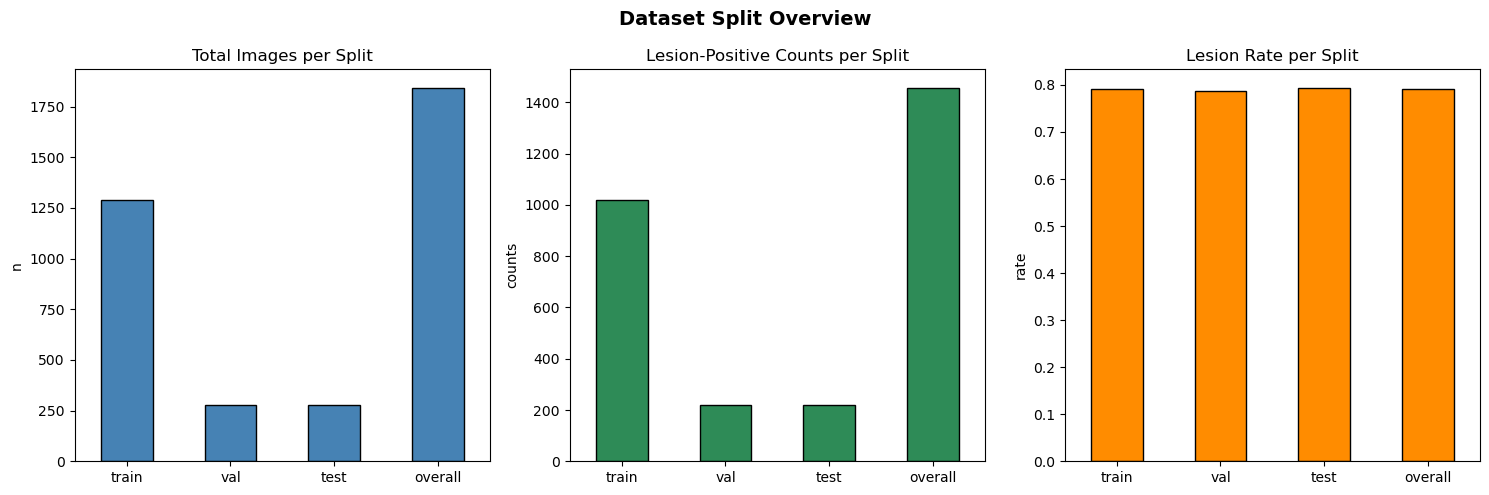

In [35]:
split_df = pd.read_csv(PATHS['split'])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

split_df.set_index("name")["n"].plot(
    kind="bar", ax=axes[0], color="steelblue", edgecolor="black"
)
axes[0].set_title("Total Images per Split")
axes[0].set_ylabel("n")
axes[0].set_xlabel("")
axes[0].tick_params(axis="x", rotation=0)

split_df.set_index("name")["counts"].plot(
    kind="bar", ax=axes[1], color="seagreen", edgecolor="black"
)
axes[1].set_title("Lesion-Positive Counts per Split")
axes[1].set_ylabel("counts")
axes[1].set_xlabel("")
axes[1].tick_params(axis="x", rotation=0)

split_df.set_index("name")["rates"].plot(
    kind="bar", ax=axes[2], color="darkorange", edgecolor="black"
)
axes[2].set_title("Lesion Rate per Split")
axes[2].set_ylabel("rate")
axes[2].set_xlabel("")
axes[2].tick_params(axis="x", rotation=0)

plt.suptitle("Dataset Split Overview", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

## Test Results

In [37]:
json = {
  "dice": 0.45,
  "iou": 0.34,
  "precision": 0.42,
  "recall": 0.36,
  "pearson": 0.415,
  "threshold": 0.55,
  "post_min_area": 24,
  "lesion": "HE"
}

---
Jakob Balkovec